In [45]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import ast
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt




### Explanation of Feature Extraction Parameters:


#### **`sr = 16000` (Sampling Rate)**  
We use a 16 kHz sampling rate because:  
- It is standard for speech processing tasks (also used in datasets like CREMA-D and others).  
- Human speech rarely contains important frequency content above 8 kHz, and by Nyquist's theorem, a 16 kHz sampling rate fully captures this without unnecessary data overhead.  
- It reduces computational load compared to 44.1 kHz or 48 kHz sampling without losing essential speech detail.  

---

#### **`n_fft = 512` (FFT window size)**  
- With `sr = 16000`, an `n_fft = 512` corresponds to a **32 ms window** (512 / 16000 = 0.032s).  
- A 32 ms window is an excellent choice because:  
  - It is long enough to capture steady-state speech characteristics like formants and stable spectral properties.  
  - It still allows reasonable time resolution to capture dynamic transitions in emotion (like sudden energy changes or articulation shifts).  
- Larger FFT windows (e.g., 1024) can smooth out short-term changes, making dynamic emotions harder to detect.  
- Smaller FFT windows (< 512) may cause frequency resolution loss.  


---

#### **`hop_length = 205` (frame step)**  
- With `sr = 16000` and `hop_length = 205`, each step is approximately **12.8 ms**.  
- This results in roughly **60% overlap** between consecutive windows (since 205 is about 40% of 512).  
- Why 60% overlap?  
  - Higher overlap ensures that no sudden changes (especially in emotional speech transitions) are missed between frames.  
  - It smooths the temporal progression of features, allowing better tracking of continuous changes in speech energy, pitch, and articulation.  
- Lower overlaps (e.g., 25%) can make transitions more "jumpy" and lose smoothness, while extremely high overlaps increase computation without significant additional benefit.


---

#### **`n_mfcc = 13` (Number of MFCC coefficients)**  
- **13 MFCC coefficients** is the classical standard for speech processing tasks.  
- These coefficients capture the shape of the vocal tract well and have been validated in both emotion and speech recognition tasks.  
- Fewer coefficients (< 13) risk losing resolution of vocal features.  
- More than 13 coefficients can start capturing noise and speaker-specific idiosyncrasies rather than emotion-relevant phonetic features.  


---


In [46]:
# === CONFIGURATION ===
preprocessed_dataset_path = os.path.join("..", "PreProcessedDataSet_for_ML")
csv_features_path = os.path.join("..", "Features", "audio_features.csv")
csv_features_path_separated = os.path.join("..", "Features", "audio_features_separated.csv")
csv_aggregated_features_path = os.path.join("..", "Features", "audio_aggregated_features.csv")
csv_final_features_path = os.path.join("..", "Features", "final_features.csv")
N_FFT = 512 # 32 ms window 
HOP_LENGTH = 205 # 12.8 ms step → 60% overlap
SR=16000 
N_MFCC=13 


### Explanation of Feature Selection and Parameter Choices for Speech Emotion Recognition (CREMA-D Dataset)

#### MFCC (Mel-Frequency Cepstral Coefficients)

**What is it?**  
MFCCs represent the short-term power spectrum of speech signals based on human auditory perception (the mel scale). They capture the shape and configuration of the vocal tract, which changes with articulation.

**Why do we use MFCC?**  
The articulation patterns of speech are strongly influenced by emotion. For example, anger and excitement cause tense, sharp articulation; sadness leads to soft, dull speech. MFCCs help model these articulatory characteristics effectively.

**Why use 13 coefficients?**  
Thirteen coefficients strike a well-established balance:  
- Fewer than 13 coefficients can underrepresent the spectrum’s important details.  
- More than 13 may start to capture irrelevant noise or speaker identity traits rather than emotion-related changes.

**Why keep both mean and standard deviation?**  
The mean MFCC vector captures the average shape of the vocal tract across the utterance. The standard deviation highlights how much the articulation changes during the utterance. Emotional speech tends to be more dynamic (e.g., sudden shifts in anger or excitement), and the std helps measure this variability.

---

#### MFCC Delta and Delta-Delta

**What are they?**  
These are the first and second-order time derivatives of the MFCC coefficients, capturing the velocity and acceleration of feature changes across frames.

**Why do we use delta and delta-delta?**  
While static MFCCs represent the spectral shape, deltas and delta-deltas capture dynamic changes in articulation, which are highly emotion-dependent. For instance, sudden changes in pitch or formants are characteristic of certain emotions.

**Why keep both mean and standard deviation?**  
The mean captures the overall direction and smoothness of changes. The standard deviation measures how stable or abrupt these dynamic transitions are. Emotions like anger or surprise often show greater fluctuations, reflected well in the std.

---

#### Zero Crossing Rate (ZCR)

**What is it?**  
ZCR is the rate at which the signal waveform crosses the zero amplitude axis. It indirectly measures the noisiness and frequency content of the speech.

**Why do we use ZCR?**  
Energetic or tense emotions (like anger or excitement) often involve more fricatives and sharper sounds, leading to higher zero crossing rates. Calm or sad speech tends to have lower ZCR.

**Why the chosen parameters?**  
We use the same frame length (`n_fft=1024`) and `hop_length=512` as for MFCCs to maintain alignment across all features and ensure consistent temporal resolution.

**Why keep both mean and standard deviation?**  
The mean ZCR gives a stable measurement of the overall noisiness or articulation sharpness. The standard deviation helps capture frame-to-frame variability, which can differentiate between calm (steady) and agitated (fluctuating) speech.

---

#### RMS Energy

**What is it?**  
RMS (Root Mean Square) energy measures the loudness of the audio signal.

**Why do we use RMS energy?**  
Emotional states heavily influence speech energy. For example, anger, happiness, and fear often result in louder, more energetic speech; sadness and boredom lower energy levels.

**Why use consistent frame analysis parameters?**  
By using `n_fft=1024` and `hop_length=512`, we align RMS measurement with other time-based features for coherence.

**Why keep both mean and standard deviation?**  
The mean energy indicates the general loudness level. The standard deviation reflects fluctuations in loudness across frames, which is key for capturing dynamic emotional expressions like sudden bursts of energy in anger or excitement.

---

#### Spectral Centroid

**What is it?**  
The spectral centroid measures the center of mass of the spectrum, indicating where most energy is concentrated in the frequency domain.

**Why do we use spectral centroid?**  
Brighter (higher centroid) signals are associated with energetic or excited emotions, while darker (lower centroid) signals indicate sadness or calmness.

**Why use only the mean?**  
Centroid values are generally stable within short utterances, and their average conveys enough discriminative power. Variance often adds noise rather than informative emotional cues, especially in clean recordings.

---

#### Spectral Bandwidth

**What is it?**  
Spectral bandwidth represents the spread of frequencies around the centroid.

**Why do we use spectral bandwidth?**  
A wider bandwidth indicates more tension and higher-frequency activity (typical in anger and excitement). Narrow bandwidth corresponds to calmer, more monotone speech.

**Why use only the mean?**  
Like the centroid, bandwidth is a relatively stable descriptor. The mean effectively captures this feature; standard deviation does not contribute meaningfully for short emotional utterances.

---

#### Spectral Rolloff

**What is it?**  
Spectral rolloff is the frequency below which a certain percentage (typically 85%) of the spectral energy lies.

**Why do we use spectral rolloff?**  
Higher rolloff values suggest more high-frequency energy, often found in tense, excited, or angry speech. Lower rolloff values are associated with soft, smooth speech, characteristic of sadness.

**Why use only the mean?**  
The rolloff tends to remain stable across frames. Variance often represents measurement noise rather than emotion-driven changes.

---

#### Spectral Contrast

**What is it?**  
Spectral contrast measures the difference between peaks and valleys in the spectral envelope, computed across frequency sub-bands.

**Why do we use spectral contrast?**  
Emotionally expressive speech (anger, excitement) exhibits stronger contrast between prominent frequencies and valleys. Monotone speech (sadness) shows lower contrast.

**Why keep both mean and standard deviation?**  
The mean contrast indicates the overall dynamic range, while the standard deviation reveals frame-to-frame articulation dynamics. Emotional fluctuations are often well captured through std.

---

#### Chroma Features

**What are they?**  
Chroma features map the energy distribution into 12 pitch classes (like musical notes), offering a compact representation of pitch-based information.

**Why do we use chroma features?**  
Although speech is not melodic, emotional intonation shifts can cause systematic changes in pitch distribution. Emotions like excitement or happiness might emphasize certain pitch ranges, while sadness flattens pitch variation.

**Why use only the mean?**  
The mean chroma vector effectively captures the overall pitch class distribution. The standard deviation of chroma features typically adds little value for emotional analysis and can introduce redundancy or noise.

---


In [47]:
# =================== FEATURE EXCTRACTION FUNCTIONS WE USED ===================
def compute_mfcc(y, sr, n_mfcc, n_fft, hop_length):

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    return mfcc

    # mfcc_mean = mfcc.mean(axis=1)
    # mfcc_std = mfcc.std(axis=1)
    
    # mfcc_delta = librosa.feature.delta(mfcc, order=1)
    # delta_mean = mfcc_delta.mean(axis=1)
    # delta_std = mfcc_delta.std(axis=1)
    
    # mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    # delta2_mean = mfcc_delta2.mean(axis=1)
    # delta2_std = mfcc_delta2.std(axis=1)

    # print(mfcc.shape)
    
    # return (mfcc_mean, mfcc_std, 
    #         delta_mean, delta_std,
    #         delta2_mean, delta2_std)

def compute_zcr(y, n_fft, hop_length):
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length)
    return zcr

def compute_rms(y, n_fft, hop_length):
    rms = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)
    return rms

def compute_centroid(y, sr, n_fft, hop_length):
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    return centroid

def compute_bandwidth(y, sr, n_fft, hop_length):
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    return bandwidth

def compute_rolloff(y, sr, n_fft, hop_length):
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    return rolloff

def compute_spectral_contrast(y, sr, n_fft, hop_length):
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    return spectral_contrast

def compute_chroma(y, sr, n_fft, hop_length):
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    return chroma

def compute_spectral_flux(y, sr, n_fft, hop_length):
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    flux = np.sqrt(np.sum(np.diff(S, axis=1)**2, axis=0))
    return flux


In [48]:
def extract_features_from_audio(file_path):
    try:
        y, _ = librosa.load(file_path, sr=SR)
        
        # MFCCs, MFCC Delta & Delta-Delta
        mfcc = compute_mfcc(y, SR, N_MFCC, N_FFT, HOP_LENGTH)

        # Zero Crossing Rate
        zcr = compute_zcr(y, N_FFT, HOP_LENGTH)

        # RMS Energy
        rms = compute_rms(y, N_FFT, HOP_LENGTH)

        # Spectral Features (only mean)
        centroid = compute_centroid(y, SR, N_FFT, HOP_LENGTH)
        bandwidth = compute_bandwidth(y, SR, N_FFT, HOP_LENGTH)
        rolloff = compute_rolloff(y, SR, N_FFT, HOP_LENGTH)

        # Spectral Contrast (mean + std)
        contrast = compute_spectral_contrast(y, SR, N_FFT, HOP_LENGTH)

        # Chroma Features (mean only)
        chroma = compute_chroma(y, SR, N_FFT, HOP_LENGTH)
        features = np.concatenate((
            mfcc, zcr, rms, centroid, bandwidth, rolloff, contrast, chroma
        ), axis=0)

        aggregated_features = np.concatenate((
            mfcc.mean(axis=1),  # Mean across the time axis for MFCC
            [zcr.mean()],  # Mean of Zero Crossing Rate
            [rms.mean()],  # Mean of RMS Energy
            [centroid.mean()],  # Mean of Spectral Centroid
            [bandwidth.mean()],  # Mean of Spectral Bandwidth
            [rolloff.mean()],  # Mean of Spectral Roll-off
            contrast.mean(axis=1),  # Mean across the time axis for Spectral Contrast
            chroma.mean(axis=1)  # Mean across the time axis for Chroma
        ))

        return features, aggregated_features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None
    

Here’s a clean, brief, and professional explanation of why each of these features was **not used** in your final extraction pipeline:  

---

### Why These Features Were Not Included:

#### 1. **Spectral Flatness**  
- **What it is:** Measures how noise-like or tone-like the signal is.  
- **Why not used:**  
  - It’s highly correlated with spectral contrast and ZCR, which we already use.  
  - Adding it would introduce redundancy rather than new information, increasing feature dimensionality unnecessarily.  

---

#### 2. **Tonnetz (Tonal Centroid Features)**  
- **What it is:** Measures harmonic relations and pitch stability, mainly used in music.  
- **Why not used:**  
  - Emotional speech rarely follows harmonic structures like music.  
  - This feature is not robust for short, non-musical utterances and may introduce noise into the feature set.  

---

#### 3. **Spectral Polynomial Coefficients**  
- **What it is:** Polynomial approximation of spectral shape.  
- **Why not used:**  
  - This feature is rarely used in speech emotion recognition research.  
  - It is often unstable, version-dependent in `librosa`, and lacks literature support for SER.  
  - Risk of overfitting without proven benefit.  

---

#### 4. **Tempogram (tempo variation)**  
- **What it is:** Describes tempo fluctuations based on onset strength.  
- **Why not used:**  
  - Emotional speech does not have strong rhythmic structures like music.  
  - Utterances in CREMA-D are short and don't show tempo variations that would meaningfully correlate with emotion.  

---

#### 5. **F0 (Pitch) Estimation**  
- **What it is:** Average pitch estimation from `pyin`.  
- **Why not used:**  
  - While pitch is emotionally relevant, `pyin` can be computationally heavy and unstable for noisy or short utterances.  
  - RMS, spectral centroid, and MFCC deltas already capture pitch and energy dynamics indirectly but more robustly.  

---

#### 6. **HNR (Harmonic-to-Noise Ratio)**  
- **What it is:** Ratio of periodic (harmonic) to noise components.  
- **Why not used:**  
  - Requires external libraries (Parselmouth), adding complexity and slowdowns.  
  - In short speech samples, HNR estimates can be unreliable, and we already capture related information through spectral contrast and ZCR.  

---


In [49]:
# # Spectral Flatness (mean & std)
# def compute_spectral_flatness(y, n_fft=1024, hop_length=512):
#     flatness = librosa.feature.spectral_flatness(y=y, n_fft=n_fft, hop_length=hop_length)
#     flatness_mean = flatness.mean()
#     flatness_std = flatness.std()
#     return flatness_mean, flatness_std

# # Tonnetz (Tonal Centroid Features)
# def compute_tonnetz(y, sr=16000):
#     y_harmonic = librosa.effects.harmonic(y)
#     tonnetz = librosa.feature.tonnetz(y=y_harmonic, sr=sr)
#     tonnetz_mean = tonnetz.mean(axis=1)
#     tonnetz_std = tonnetz.std(axis=1)
#     return tonnetz_mean, tonnetz_std

# # Spectral Polynomial Coefficients (if supported by your librosa version)
# def compute_spectral_poly(y, sr=16000, n_fft=1024, hop_length=512, order=2):
#     try:
#         spec_poly = librosa.feature.spectral_polynomial(y=y, sr=sr, order=order, n_fft=n_fft, hop_length=hop_length)
#         spec_poly_mean = spec_poly.mean(axis=1)
#         spec_poly_std = spec_poly.std(axis=1)
#         return spec_poly_mean, spec_poly_std
#     except AttributeError:
#         print("spectral_polynomial not available in this librosa version.")
#         return np.array([]), np.array([])

# # Tempogram (tempo variation features)
# def compute_tempogram(y, sr=16000, hop_length=512):
#     onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
#     tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr, hop_length=hop_length)
#     tempogram_mean = tempogram.mean(axis=1)
#     tempogram_std = tempogram.std(axis=1)
#     return tempogram_mean, tempogram_std

# # F0 (Pitch) Estimation using librosa.pyin
# def compute_pitch(y, sr=16000):
#     f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
#     f0_nonan = f0[~np.isnan(f0)]
#     if len(f0_nonan) == 0:
#         return 0.0, 0.0
#     f0_mean = np.mean(f0_nonan)
#     f0_std = np.std(f0_nonan)
#     return f0_mean, f0_std

# # Harmonic-to-Noise Ratio (HNR)
# import parselmouth
# def compute_hnr(y, sr=16000):
#     try:
#         sound = parselmouth.Sound(y, sampling_frequency=sr)
#         pointProcess = sound.to_point_process_cc()
#         hnr_values = sound.to_harmonicity_ac().values.T
#         hnr_nonan = hnr_values[~np.isnan(hnr_values)]
#         if len(hnr_nonan) == 0:
#             return 0.0, 0.0
#         hnr_mean = np.mean(hnr_nonan)
#         hnr_std = np.std(hnr_nonan)
#         return hnr_mean, hnr_std
#     except Exception as e:
#         print(f"Error computing HNR: {e}")
#         return 0.0, 0.0


Main pipeLine so that each audio gets its features extracted!

In [50]:
# Feature column names
mfcc_cols = [f"mfcc{i+1}" for i in range(13)]

spec_cols = [
    "zcr",
    "rms",
    "centroid",
    "bandwidth",
    "rolloff"
]

contrast_cols = [f"spectral_contrast_band{i+1}" for i in range(7)] 

chroma_cols = [f"chroma{i+1}" for i in range(12)]

all_feature_names = mfcc_cols + spec_cols + contrast_cols + chroma_cols

In [51]:
features = []
aggregated_features = []
filenames = []
emotions = []
i = 0

for file in os.listdir(preprocessed_dataset_path):
    if file.lower().endswith(".wav"):
        path = os.path.join(preprocessed_dataset_path, file)
        result, aggregated_result = extract_features_from_audio(path)
        if result is not None and aggregated_result is not None:
            parts = file.split('_')
            emotion = parts[2]
            print(f"features are extracted from : {file}")
            feature_vector = [list(feature) for feature in result]
            features.append(feature_vector)
            aggregated_features.append(aggregated_result)
            filenames.append(file)
            emotions.append(emotion)

# print("Number of audio files:", len(features))
# print("Number of features per file:", len(features[0])) 
# print("Number of frames per feature:", len(features[0][0])) 

encoder = LabelEncoder()
encoded_emotions = encoder.fit_transform(emotions)

print("started writing features to csv file..")
df_framewise_features = pd.DataFrame(features, columns=all_feature_names)
df_framewise_features.insert(0, "file_name", filenames)
df_framewise_features['emotion'] = encoded_emotions
df_framewise_features.to_csv(csv_features_path, index=False)

print("started writing aggregated features to csv file..")
df_aggregated_features = pd.DataFrame(aggregated_features, columns=all_feature_names)
df_aggregated_features.insert(0, "file_name", filenames)
df_aggregated_features['emotion'] = encoded_emotions
df_aggregated_features.to_csv(csv_aggregated_features_path, index=False)

features are extracted from : 1001_DFA_ANG_XX.wav_chunk1.wav
features are extracted from : 1001_DFA_ANG_XX.wav_chunk2.wav
features are extracted from : 1001_DFA_ANG_XX.wav_chunk3.wav
features are extracted from : 1001_DFA_ANG_XX.wav_chunk4.wav
features are extracted from : 1001_DFA_ANG_XX.wav_chunk5.wav
features are extracted from : 1001_DFA_DIS_XX.wav_chunk1.wav
features are extracted from : 1001_DFA_DIS_XX.wav_chunk2.wav
features are extracted from : 1001_DFA_DIS_XX.wav_chunk3.wav
features are extracted from : 1001_DFA_DIS_XX.wav_chunk4.wav
features are extracted from : 1001_DFA_DIS_XX.wav_chunk5.wav
features are extracted from : 1001_DFA_FEA_XX.wav_chunk1.wav
features are extracted from : 1001_DFA_FEA_XX.wav_chunk2.wav
features are extracted from : 1001_DFA_FEA_XX.wav_chunk3.wav
features are extracted from : 1001_DFA_FEA_XX.wav_chunk4.wav
features are extracted from : 1001_DFA_FEA_XX.wav_chunk5.wav
features are extracted from : 1001_DFA_HAP_XX.wav_chunk1.wav
features are extracted f

In [52]:
# df_framewise_features = pd.read_csv(csv_features_path)

# emotion_mapping = {
#     0: 'ANG',
#     1: 'DIS',
#     2: 'FEA',
#     3: 'HAP',
#     4: 'NEU',
#     5: 'SAD'
# }

# import ast

# def clean_and_eval(val):
#     try:
#         if isinstance(val, str):
#             val = val.replace("np.float64(", "").replace(")", "")
#             return ast.literal_eval(val)
#         else:
#             return val
#     except (ValueError, SyntaxError):
#         print("Problem with value:", val)
#         return val

# # Optional: Convert stringified lists back to actual Python lists
# for feature in all_feature_names:
#     print(f"working on feature: {feature}")
#     df_framewise_features[feature] = df_framewise_features[feature].apply(clean_and_eval)


# # Create a copy to modify
# new_df = df_framewise_features.copy()

# # Expand list-valued columns into multiple columns
# for feature in all_feature_names:
#     expanded_df = pd.DataFrame(
#         new_df[feature].tolist(),
#         columns=[f"{feature}_{i}" for i in range(len(new_df[feature][0]))]
#     )
#     # Drop the original list column
#     new_df = new_df.drop(columns=[feature])
#     # Add the new expanded columns
#     new_df = pd.concat([new_df, expanded_df], axis=1)

# new_df["emotion_category"] = new_df["emotion"].map(emotion_mapping)

# # Save the transformed DataFrame

In [53]:
# new_df.to_csv(csv_features_path_separated, index=False)

# # All MFCC framewise columns
# mfcc_cols = [col for col in df.columns if col.startswith("mfcc")]

# # Melt the framewise features into long format
# long_df = df.melt(
#     id_vars=["file_name", "emotion", "emotion_category"],
#     value_vars=mfcc_cols,
#     var_name="feature_frame",
#     value_name="value"
# )

# # Extract frame number and feature name
# long_df['frame'] = long_df['feature_frame'].str.extract(r'_(\d+)$').astype(int)
# long_df['feature'] = long_df['feature_frame'].str.extract(r'^(mfcc\d+)')

# # Optional: re-order columns
# long_df = long_df[['file_name', 'emotion', 'emotion_category', 'feature', 'frame', 'value']]

# # Save to new CSV for Power BI
# long_df.to_csv("reshaped_framewise.csv", index=False)


In [54]:
df_aggregated_features = pd.read_csv(csv_aggregated_features_path)

# Create a copy of the original DataFrame
new_df = df_aggregated_features.copy()

# Add the decoded emotion labels
new_df["emotion_category"] = new_df["emotion"].map(emotion_mapping)

new_df.to_csv("helper/emotion_encoding_map.csv", index=False)

In [55]:
# # Optional: drop non-feature columns like 'emotion', 'filename'.
# plot_df = pd.read_csv(csv_aggregated_features_path)

# plot_df["chroma_mean"] = plot_df[chroma_cols].mean(axis=1)
# plot_df["mfcc_mean"] = plot_df[mfcc_cols].mean(axis=1)
# plot_df["contrast_mean"] = plot_df[contrast_cols].mean(axis=1)

# spec_cols = [
#     "zcr",
#     "rms",
#     "centroid",
#     "bandwidth",
#     "rolloff"
# ]

# feature_df = plot_df[spec_cols + ["chroma_mean", "mfcc_mean", "contrast_mean"]]

# # Compute the correlation matrix
# correlation_matrix = feature_df.corr(method='pearson')

# correlation_matrix.to_csv("Analytics/correlation_heatmap.csv")

# # Plot the heatmap
# plt.figure(figsize=(12, 10))
# sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
# plt.title("Correlation Heatmap of Aggregated Audio Features", fontsize=14)
# plt.tight_layout()
# plt.savefig("Analytics/correlation_heatmap.png", dpi=300)
# plt.close()


In [56]:
# from scipy.spatial import ConvexHull

# hull_areas = {}
# for emotion in pca_df["Emotion"].unique():
#     emotion_points = pca_df[pca_df["Emotion"] == emotion][["PC1", "PC2"]].values
#     try:
#         hull = ConvexHull(emotion_points)
#         hull_areas[emotion] = hull.volume  # area in 2D
#     except:
#         hull_areas[emotion] = 0  # if there are not enough points to compute hull

# # --- Convert to DataFrame for plotting ---
# hull_df = pd.DataFrame.from_dict(hull_areas, orient="index", columns=["ConvexHullArea"]).reset_index()
# hull_df = hull_df.rename(columns={"index": "Emotion"})

# # --- Barplot ---
# plt.figure(figsize=(10, 6))
# sns.barplot(data=hull_df, x="Emotion", y="ConvexHullArea", palette="Set2")
# plt.title("Convex Hull Area per Emotion (Spread in PCA Space)")
# plt.xlabel("Emotion")
# plt.ylabel("Convex Hull Area")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


In [57]:
# plot_df = pd.read_csv(r"helper/emotion_encoding_map.csv")

# plot_df[all_feature_names] = plot_df[all_feature_names].abs()

# mean_by_emotion = plot_df.groupby("emotion_category")[all_feature_names].mean().reset_index()
# os.makedirs("feature_emotion_barplot", exist_ok = True)
# # Generate bar plots
# sns.set(style="whitegrid")
 
# for feature in all_feature_names:
#     plt.figure(figsize=(8, 5))
#     sns.barplot(x="emotion_category", y=feature, data=mean_by_emotion)
#     plt.title(f"Average {feature} by Emotion")
#     plt.ylabel(f"{feature} (mean)")
#     plt.xlabel("Emotion")
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.savefig(f"feature_emotion_barplot/{feature}_bar_chart.png", dpi=300)
#     plt.close()

In [58]:
# plot_df = pd.read_csv(r"helper/emotion_encoding_map.csv")

# plot_df[all_feature_names] = plot_df[all_feature_names].abs()

# os.makedirs("feature_emotion_barplot", exist_ok = True)

# all_feature_names = ["mfcc1"]

# for feature in all_feature_names:
#     plt.figure(figsize=(8, 5))
#     sns.violinplot(data=plot_df, x="emotion", y=feature, inner="quartile")
#     plt.title(f"{feature} Distribution by Emotion")
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.savefig(f"feature_emotion_barplot/{feature}_violinplot.png", dpi=300)
#     plt.close()

In [59]:
# Define features and target
X = df_aggregated_features.iloc[:, 1:-1]  # Features: all columns except first (filename) and last (target)
y = df_aggregated_features.iloc[:, -1]    # Target: last column

# Compute Mutual Information
mutual_info = mutual_info_classif(X, y)

# Compute Correlation (Pearson)
correlations = X.corrwith(y)

# Combine into a single DataFrame
aggregated_MI_corr_df = pd.DataFrame({ 
    "Feature": X.columns,
    "Mutual Information": mutual_info,
    "Correlation": correlations
})

aggregated_MI_corr_df.to_csv("Analytics/mi_corr_aggregated_features.csv", index=False)

In [60]:
feature_columns = df_framewise_features.columns[1:-1]
results = []

# Loop through each feature
for feature_name in feature_columns:
    # Parse the list into 2D array
    feature_series = df_framewise_features[feature_name].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    X = np.stack(feature_series.values)

    # Create frame-wise DataFrame
    frame_df = pd.DataFrame(X, columns=[f"{feature_name}_frame_{i}" for i in range(X.shape[1])])

    # Pearson correlation
    corr = frame_df.corrwith(y)

    # Mutual information
    mi = mutual_info_classif(frame_df, y, discrete_features=False)

    # Combine into result list
    for i in range(X.shape[1]):
        results.append({
            "Feature": feature_name,
            "Frame": i,
            "Frame_Name": f"{feature_name}_frame_{i}",
            "Correlation": corr.iloc[i],
            "Mutual Information": mi[i]
        })

# Combine into a single DataFrame
framewise_MI_corr_df = pd.DataFrame(results)

framewise_MI_corr_df.to_csv("Analytics/framewise_mi_corr_all_features.csv", index=False)

In [61]:
# plot_dir = "plot_feature_mi_corr"
# os.makedirs(plot_dir, exist_ok=True)

# def plot_feature_mi_corr(feature_name, framewise_df, aggregated_df):
#     # Filter data
#     df_feat = framewise_df[framewise_df["Feature"] == feature_name].reset_index(drop=True)

#     agg_row = aggregated_df[aggregated_df["Feature"] == feature_name].reset_index(drop=True)
#     agg_mi = agg_row["Mutual Information"].values[0]
#     agg_corr = abs(agg_row["Correlation"].values[0])

#     # Plot
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

#     # MI plot
#     ax1.bar(df_feat["Frame"], df_feat["Mutual Information"], color="skyblue", alpha=0.8, label="MI per Frame")
#     ax1.axhline(y=agg_mi, color="blue", linestyle="--", linewidth=2, label="Aggregated MI")
#     ax1.set_title(f"Mutual Information — {feature_name}")
#     ax1.set_xlabel("Frame")
#     ax1.set_ylabel("Mutual Information")
#     ax1.legend()
#     ax1.grid(True)

#     # Correlation plot
#     ax2.bar(df_feat["Frame"], np.abs(df_feat["Correlation"]), color="salmon", alpha=0.8, label="|Correlation| per Frame")
#     ax2.axhline(y=agg_corr, color="red", linestyle="--", linewidth=2, label="|Aggregated Correlation|")
#     ax2.set_title(f"Absolute Correlation — {feature_name}")
#     ax2.set_xlabel("Frame")
#     ax2.set_ylabel("|Correlation|")
#     ax2.legend()
#     ax2.grid(True)

#     plt.tight_layout()
#     plt.savefig(f"{plot_dir}/{feature_name}_mi_corr_plot.png", dpi=300)
#     plt.close()

# for feature in all_feature_names:
#     plot_feature_mi_corr(feature, framewise_MI_corr_df, aggregated_MI_corr_df) 


In [62]:
# pca_analysis_dir = "pca_analysis"
# os.makedirs(pca_analysis_dir, exist_ok=True)

# # Define the plotting function
# def plot_pca_for_feature(df_column, feature_name):
#     feature_series = df_column.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
#     X = np.stack(feature_series.values)
    
#     pca = PCA()
#     pca.fit(X)
#     explained = np.cumsum(pca.explained_variance_ratio_)

#     plt.figure(figsize=(6, 4))
#     plt.plot(explained, marker='o')
#     plt.title(f"PCA - Cumulative Variance for {feature_name}")
#     plt.xlabel("Number of Components")
#     plt.ylabel("Cumulative Variance Explained")
#     plt.grid(True)
#     plt.tight_layout()

#     plt.savefig(f"{pca_analysis_dir}/{feature_name}_correlation_heatmap.png", dpi=300)
#     plt.close()

# # Loop and plot PCA for each feature column
# for feature_name in all_feature_names:
#     plot_pca_for_feature(df_framewise_features[feature_name], feature_name)


In [63]:
# heatmap_dir = "correlation_matrix_between_time_frames"
# os.makedirs(heatmap_dir, exist_ok=True)

# def plot_correlation_matrix(feature_name):
#     feature_series = df_framewise_features[feature_name].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
#     X = np.stack(feature_series.values)

#     X_first_10 = X[:, :10]
#     corr_matrix = np.corrcoef(X_first_10.T)

#     plt.figure(figsize=(8, 6))
#     sns.heatmap(corr_matrix, cmap="coolwarm", center=0, square=True, annot=True, fmt=".2f")
#     plt.title(f"Correlation Matrix of {feature_name}")
#     plt.xlabel("Time Step")
#     plt.ylabel("Time Step")
#     plt.tight_layout()
    
#     plt.savefig(f"{heatmap_dir}/{feature_name}_correlation_heatmap.png", dpi=300)
#     plt.close()

# # Run the analysis for each feature
# for feature_name in all_feature_names:
#     plot_correlation_matrix(feature_name)

In [64]:
final_df = pd.DataFrame()

# Loop through all features
for feature in all_feature_names:
    # Get aggregated MI
    agg_mi = aggregated_MI_corr_df.loc[aggregated_MI_corr_df["Feature"] == feature, "Mutual Information"].values[0]
    
    # Get max framewise MI
    max_frame_mi = framewise_MI_corr_df[framewise_MI_corr_df["Feature"] == feature]["Mutual Information"].max()

    # Choose version with higher MI
    if max_frame_mi > agg_mi:
        print(feature)
        final_df[feature] = df_framewise_features[feature]
    else:
        final_df[feature] = df_aggregated_features[feature]

final_df.insert(0, "file_name", df_framewise_features["file_name"])
final_df["emotion"] = df_framewise_features["emotion"]

final_df.to_csv(csv_final_features_path, index=False)

print("Final features saved")

mfcc1
mfcc7
mfcc9
mfcc12
rms
bandwidth
rolloff
spectral_contrast_band1
chroma2
Final features saved


In [65]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.set(style="whitegrid")
# plt.figure(figsize=(8, 6))
# sns.scatterplot(
#     x="centroid", 
#     y="zcr", 
#     hue="emotion", 
#     data=df_aggregated_features
# )
# plt.title("Feature Scatter: Centroid vs ZCR")
# plt.xlabel("Spectral Centroid")
# plt.ylabel("Zero Crossing Rate")
# plt.legend(title="Emotion")
# plt.tight_layout()
# plt.show()

In [66]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.set(style="whitegrid")
# plt.figure(figsize=(8, 6))
# sns.scatterplot(
#     x="rolloff", 
#     y="centroid", 
#     hue="emotion", 
#     data=df_aggregated_features
# )
# plt.title("Feature Scatter: Centroid vs ZCR")
# plt.xlabel("Spectral Centroid")
# plt.ylabel("Zero Crossing Rate")
# plt.legend(title="Emotion")
# plt.tight_layout()
# plt.show()


In [67]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Make output folder
os.makedirs("feature_histograms", exist_ok=True)
sns.set(style="whitegrid")

plot_df = pd.read_csv(r"helper/emotion_encoding_map.csv")

mfcc_cols = [f"mfcc{i+1}" for i in range(13)]

spec_cols = [
    "zcr",
    "rms",
    "centroid",
    "bandwidth",
    "rolloff"
]

contrast_cols = [f"spectral_contrast_band{i+1}" for i in range(7)] 

chroma_cols = [f"chroma{i+1}" for i in range(12)]

plot_df["chroma_mean"] = plot_df[chroma_cols].mean(axis=1)

all_feature_names = mfcc_cols + spec_cols + contrast_cols + chroma_cols + ["chroma_mean"]

# # Loop through all features
# for feature in all_feature_names:
#     plt.figure(figsize=(8, 5))
#     sns.histplot(plot_df[feature], bins=30, kde=False)
#     plt.title(f"Distribution of {feature}")
#     plt.xlabel(feature)
#     plt.ylabel("Frequency")
#     plt.tight_layout()
#     plt.savefig(f"feature_histograms/{feature}_histogram.png", dpi=300)
#     plt.close()


In [68]:
# os.makedirs("self_feature_plots", exist_ok=True)
# plot_df = pd.read_csv(r"helper/emotion_encoding_map.csv")

# for feature in ['rms', 'zcr', 'centroid', 'mfcc1', 'mfcc2']:
#     plt.figure(figsize=(8, 5))
#     sns.kdeplot(data=plot_df, x=feature, hue="emotion_category", common_norm=False, fill=True, alpha=0.3)
#     plt.title(f"{feature} Distribution by Emotion")
#     plt.xlabel(feature)
#     plt.ylabel("Density")
#     plt.tight_layout()
#     plt.savefig(f"self_feature_plots/{feature}_self_plot.png", dpi=300)
#     plt.close()

In [69]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import os

# plot_df = pd.read_csv(r"helper/emotion_encoding_map.csv")
# chroma_cols = [f"chroma{i}" for i in range(1, 13)]

# # Create folder to save plots
# os.makedirs("Analytics/chroma_profiles", exist_ok=True)

# for emotion_name in plot_df["emotion_category"].unique():
#     chroma_mean = plot_df[plot_df["emotion_category"] == emotion_name][chroma_cols].mean()

#     plt.figure(figsize=(8, 5))
#     chroma_mean.plot(kind='bar', color='mediumseagreen')
#     plt.title(f"Average Chroma Profile for {emotion_name.capitalize()}")
#     plt.xlabel("Chroma (Pitch Class)")
#     plt.ylabel("Average Value")
#     plt.ylim(0, 0.65) 
#     plt.xticks(rotation=0)
#     plt.tight_layout()
#     plt.savefig(f"Analytics/chroma_profiles/{emotion_name}_chroma_bar.png", dpi=300)
#     plt.close()


In [70]:
# plot_df["total_chroma"] = plot_df[[f"chroma{i}" for i in range(1, 13)]].sum(axis=1)

# chroma_by_emotion = plot_df.groupby("emotion_category")["total_chroma"].mean().sort_values(ascending=False)

# plt.figure(figsize=(8, 5))
# chroma_by_emotion.plot(kind="bar", color="mediumpurple")
# plt.title("Average Total Chroma Energy per Emotion")
# plt.xlabel("Emotion")
# plt.ylabel("Total Chroma (Sum of chroma1–12)")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()



In [71]:
# plot_df = pd.read_csv(r"helper/emotion_encoding_map.csv")
# mfcc_cols = [f"mfcc{i}" for i in range(1, 14)]

# # Create folder to save plots
# os.makedirs("Analytics/mfcc_profiles", exist_ok=True)

# for emotion_name in plot_df["emotion_category"].unique():
#     mfcc_mean = plot_df[plot_df["emotion_category"] == emotion_name][mfcc_cols].mean().abs()

#     plt.figure(figsize=(8, 5))
#     mfcc_mean.plot(kind='bar', color='mediumseagreen')
#     plt.title(f"Average mfcc Profile for {emotion_name.capitalize()}")
#     plt.xlabel("mfcc")
#     plt.ylabel("Average Value")
#     plt.ylim(0, 550) 
#     plt.xticks(rotation=0)
#     plt.tight_layout()
#     plt.savefig(f"Analytics/mfcc_profiles/{emotion_name}_mfcc_bar.png", dpi=300)
#     plt.close()




In [72]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load Data ---
plot_df = pd.read_csv("helper/emotion_encoding_map.csv")
emotion_col = "emotion_category"

# --- Define Feature Columns ---
all_feature_names = [col for col in plot_df.columns if col.startswith((
    'mfcc', 'chroma', 'spectral', 'zcr', 'rms', 'centroid', 'rolloff', 'bandwidth'))]

# --- Compute Mutual Information ---
X = plot_df[all_feature_names]
y = plot_df[emotion_col]
mi_scores = mutual_info_classif(X, y, discrete_features=False)

# --- Compute Mean Inter-Class Distance (Spread) ---
def inter_class_distance(feature):
    means = plot_df.groupby(emotion_col)[feature].mean()
    distances = [abs(a - b) for a, b in combinations(means, 2)]
    return np.mean(distances)

spread_scores = {feat: inter_class_distance(feat) for feat in all_feature_names}

# --- Combine into DataFrame ---
mi_spread_df = pd.DataFrame({
    "feature": all_feature_names,
    "spread_score": [spread_scores[feat] for feat in all_feature_names],
    "mi_score": mi_scores
}).sort_values(by="mi_score", ascending=False)

# # --- Plot MI vs Spread ---
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=mi_spread_df, x="spread_score", y="mi_score", s=60)
# for i, row in mi_spread_df.iterrows():
#     plt.text(row["spread_score"], row["mi_score"], row["feature"], fontsize=9)

# plt.xlabel("Mean Inter-Class Distance (Spread Score)")
# plt.ylabel("Mutual Information with Emotion")
# plt.title("Do Features with Greater Spread Have Higher MI?")
# plt.grid(True)
# plt.tight_layout()
plt.show()


In [73]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif, f_classif
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load your data ---
plot_df = pd.read_csv("helper/emotion_encoding_map.csv")
emotion_col = "emotion"

plot_df["chroma_mean"] = plot_df[chroma_cols].mean(axis=1)
plot_df["mfcc_mean"] = plot_df[mfcc_cols].mean(axis=1)
plot_df["contrast_mean"] = plot_df[contrast_cols].mean(axis=1)

# --- Define your features ---
all_feature_names = [col for col in plot_df.columns if col.startswith((
    'mfcc_mean', 'chroma_mean', 'contrast_mean', 'zcr', 'rms', 'centroid', 'rolloff', 'bandwidth'))]

X = plot_df[all_feature_names]
y = plot_df[emotion_col]

# --- Compute MI ---
mi_scores = mutual_info_classif(X, y, discrete_features=False)

grouped = plot_df.groupby(emotion_col)
means = grouped[all_feature_names].mean()
inter_class_variance = means.var()
within_class_variance = grouped[all_feature_names].var().mean()
anova_ratio = inter_class_variance / within_class_variance

correlations = plot_df[all_feature_names].corrwith(plot_df["emotion"])

anova_mi_cor_df = pd.DataFrame({
    "feature": all_feature_names,
    "anova_ratio": anova_ratio.values,
    "mi": mi_scores,
    "correlation": correlations.values
})

anova_mi_cor_df.to_csv("Analytics/anova_mi_cor_df.csv", index=False)




In [74]:
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# --- Load your data ---
plot_df = pd.read_csv("helper/emotion_encoding_map.csv")
emotion_col = "emotion_category"

all_feature_names = [col for col in plot_df.columns if col.startswith((
    'mfcc', 'chroma', 'spectral', 'zcr', 'rms', 'centroid', 'rolloff', 'bandwidth'))]

# --- Compute ANOVA Spread Ratio ---
grouped = plot_df.groupby(emotion_col)
means = grouped[all_feature_names].mean()
inter_class_variance = means.var()
within_class_variance = grouped[all_feature_names].var().mean()
anova_ratio = inter_class_variance / within_class_variance

# --- Compute correlation with emotion labels ---
correlations = plot_df[all_feature_names].corrwith(plot_df["emotion"])

# --- Combine both into a DataFrame ---
anova_corr_df = pd.DataFrame({
    "feature": all_feature_names,
    "anova_ratio": anova_ratio.values,
    "correlation": correlations.values
}).sort_values(by="anova_ratio", ascending=False)

# # --- Plot ---
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=anova_corr_df, x="anova_ratio", y="correlation", s=80)
# for i, row in anova_corr_df.iterrows():
#     plt.text(row["anova_ratio"], row["correlation"], row["feature"], fontsize=9)

# plt.xlabel("ANOVA Spread Ratio")
# plt.ylabel("Correlation with Encoded Emotion Label")
# plt.title("ANOVA Spread vs Correlation")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [75]:
# # Reload DataFrame just to be sure
# df = anova_mi_cor_df

# # === Plot 1: MI vs Correlation ===
# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=df, x="mi", y="correlation", s=80)
# for _, row in df.iterrows():
#     plt.text(row["mi"], row["correlation"], row["feature"], fontsize=8)
# plt.xlabel("Mutual Information")
# plt.ylabel("Correlation with Emotion Label")
# plt.title("MI vs Correlation")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # === Plot 2: ANOVA vs Correlation ===
# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=df, x="anova_ratio", y="correlation", s=80)
# for _, row in df.iterrows():
#     plt.text(row["anova_ratio"], row["correlation"], row["feature"], fontsize=8)
# plt.xlabel("ANOVA Ratio")
# plt.ylabel("Correlation with Emotion Label")
# plt.title("ANOVA Ratio vs Correlation")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # === Plot 3: MI vs ANOVA ===
# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=df, x="anova_ratio", y="mi", s=80)
# for _, row in df.iterrows():
#     plt.text(row["anova_ratio"], row["mi"], row["feature"], fontsize=8)
# plt.xlabel("ANOVA Ratio")
# plt.ylabel("Mutual Information")
# plt.title("MI vs ANOVA Ratio")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [76]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Violin plot for chroma10
# plt.figure(figsize=(8, 5))
# sns.violinplot(x="emotion_category", y="chroma10", data=plot_df, palette="Set2")
# plt.title("Distribution of chroma10 by Emotion")
# plt.xlabel("Emotion")
# plt.ylabel("chroma10")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # Violin plot for rms
# plt.figure(figsize=(8, 5))
# sns.violinplot(x="emotion_category", y="rms", data=plot_df, palette="Set3")
# plt.title("Distribution of rms by Emotion")
# plt.xlabel("Emotion")
# plt.ylabel("rms")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


C:\Users\NoteBook\AppData\Local\Temp\ipykernel_13876\525573501.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Emotion", y=pc, data=pca_df, palette="Set2")


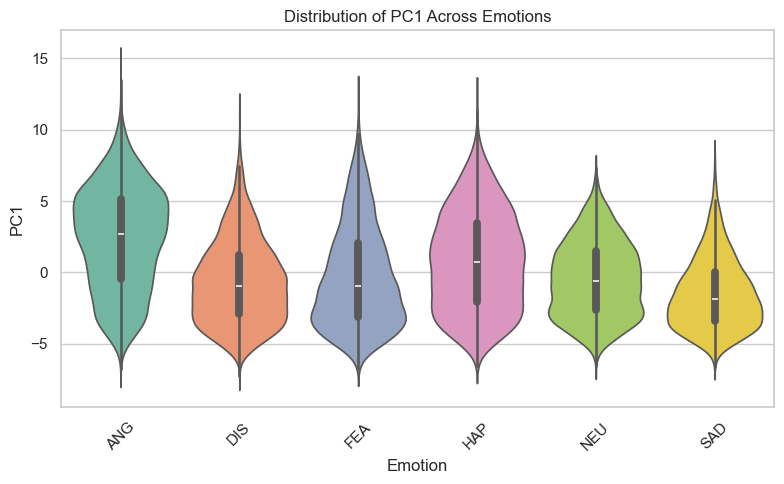

C:\Users\NoteBook\AppData\Local\Temp\ipykernel_13876\525573501.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Emotion", y=pc, data=pca_df, palette="Set2")


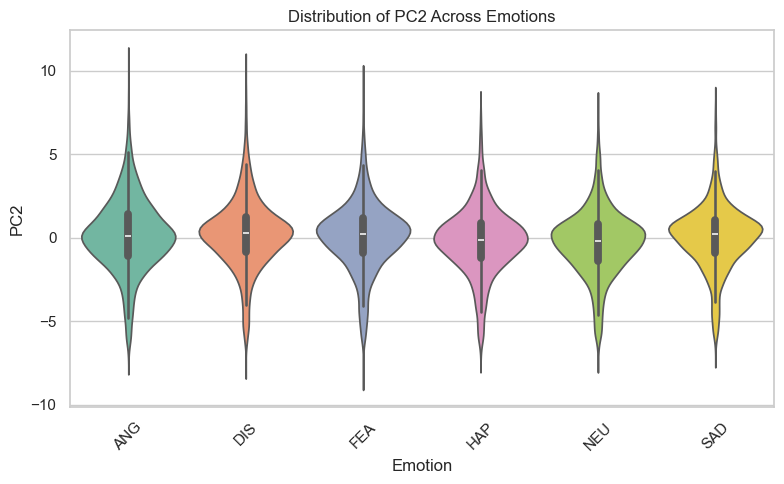

In [77]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the dataset ---
plot_df = pd.read_csv("helper/emotion_encoding_map.csv")

# --- Select features ---
features = [col for col in plot_df.columns if col.startswith((
    'mfcc', 'chroma', 'spectral', 'zcr', 'rms', 'centroid', 'rolloff', 'bandwidth'))]
X = plot_df[features]
y = plot_df["emotion_category"]  # or "emotion" if your label column has that name

# --- Standardize features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Apply PCA ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# --- Create a new DataFrame for plotting ---
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Emotion"] = y

pca_df.to_csv("Analytics/pca_df.csv")

# # --- Plot PCA result ---
# plt.figure(figsize=(10, 7))
# sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Emotion", palette="Set2", s=60)
# plt.title("PCA – Emotion Clusters in Feature Space")
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

sns.set(style="whitegrid")

for pc in ["PC1", "PC2"]:
    plt.figure(figsize=(8, 5))
    sns.violinplot(x="Emotion", y=pc, data=pca_df, palette="Set2")
    plt.title(f"Distribution of {pc} Across Emotions")
    plt.xlabel("Emotion")
    plt.ylabel(pc)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [78]:
from scipy.spatial import ConvexHull

hull_areas = {}
for emotion in pca_df["Emotion"].unique():
    emotion_points = pca_df[pca_df["Emotion"] == emotion][["PC1", "PC2"]].values
    try:
        hull = ConvexHull(emotion_points)
        hull_areas[emotion] = hull.volume  # area in 2D
    except:
        hull_areas[emotion] = 0  # if there are not enough points to compute hull

# --- Convert to DataFrame for plotting ---
hull_df = pd.DataFrame.from_dict(hull_areas, orient="index", columns=["ConvexHullArea"]).reset_index()
hull_df = hull_df.rename(columns={"index": "Emotion"})

# # --- Barplot ---
# plt.figure(figsize=(10, 6))
# sns.barplot(data=hull_df, x="Emotion", y="ConvexHullArea", palette="Set2")
# plt.title("Convex Hull Area per Emotion (Spread in PCA Space)")
# plt.xlabel("Emotion")
# plt.ylabel("Convex Hull Area")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


In [79]:
from sklearn.metrics import silhouette_score

score = silhouette_score(pca_df[["PC1", "PC2"]], pca_df["Emotion"])


In [80]:
print(score)

-0.10067850137589433


In [81]:
from scipy.spatial.distance import euclidean
from itertools import combinations
import pandas as pd

# --- Group by emotion and compute centroids ---
centroids = pca_df.groupby("Emotion")[["PC1", "PC2"]].mean()

# --- Compute Euclidean distance between every pair of centroids ---
distance_data = []
for emo1, emo2 in combinations(centroids.index, 2):
    dist = euclidean(centroids.loc[emo1], centroids.loc[emo2])
    distance_data.append({
        "Emotion 1": emo1,
        "Emotion 2": emo2,
        "Centroid Distance": dist
    })

# --- Create a DataFrame of distances ---
centroid_distances_df = pd.DataFrame(distance_data)

# Optional: Sort by distance
centroid_distances_df = centroid_distances_df.sort_values(by="Centroid Distance", ascending=False)

# Display or save
centroid_distances_df.to_csv("Analytics/centroid_distances.csv", index=False)
